# Libraries

In [177]:
#        DATA
# ==================== #
import pandas as pd
import numpy as np
from scipy import stats
import time
import random
import math

#      PLOTING
# ============================== #

from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

#      TimeSeries
# ============================================================================== #
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf , pacf
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

#      OTHERS
# ============================== #
from sklearn.inspection import permutation_importance
import multiprocessing

from python.funcionesPropias import *

#      WARNINGS
# ============================== #
import warnings
warnings.filterwarnings("ignore")
import dill

In [112]:
lineasMetro = pd.read_csv('../metroAnalisis/data/lineasMetro.csv' , encoding= 'latin-1')

In [113]:
lineasMetro['Línea'] = lineasMetro.index
lineasMetro.fillna('-', inplace= True )
lineasMetro['Terminales'] = lineasMetro['Terminales'].apply(lambda x : '-'.join(x.split('\x96'))  if len(x.split('\x96')) >1 else x )
lineasMetro.drop(['Gálibo','Andén'], axis = 1, inplace= True)

# Motivación

El Metro de Madrid fué inagurado en $1919$ por el rey Alfonso XIII, aquella primera "red" de Metro constaba únicamente con ocho paradas, desde la Puerta del Sol hasta Cuatro Caminos. Tuvo tal éxito el nuevo medio de transporte en la ciudad que fué usado por más de 14 millones de usuarios.

Actualmente el Metro de Madrid, es la segunda red de metro mas extensa de la Unión Europea y la cuerta del mundo, consta de $13$ líneas con $278$ paradas distribuidas por toda la ciudad, creando una gran red de transporte de casi $290$km, estableciendo la red de transporte más eficiente de la capital.

In [114]:
display(lineasMetro.set_index('Línea'))
print('Tabla extraída de wikipedia')

,Terminales,Longitud,Estaciones
Línea,,,
0,Pinar de Chamartín - Valdecarros,"20,8 km",31
1,Las Rosas - Cuatro Caminos,14 km,20
2,Villaverde Alto - Moncloa,"16,4 km",18
3,Argüelles - Pinar de Chamartín,16 km,23
4,Alameda de Osuna - Casa de Campo,"23,2 km",32
5,Circular,"23,5 km",28
6,Hospital de Henares - Pitis,"31,2 km",29
7,Nuevos Ministerios - Aeropuerto T4,"16,5 km",8
8,Paco de Lucía - Arganda del Rey,"38,0 km",26


Tabla extraída de wikipedia


En la Comunidad de Madrid (CAM) el transporte público preferido por los Madrileños es el Metro y en los tiempos que nos encontramos (de pandemia), resultaría interesante estimar el volumen de pasajeros que recibirá el Metro en distintos instantes del tiempo.

Apoyados en la temperatura, viento, presión atmosférica y cantidad de rayoUV, vamos a intentar predecir la cantidad de viajeros en el metro de manera mensual (debido a que no he encontrado datos diarios, o incluso por horas).

In [115]:
df = pd.read_csv('./data/dfFinal.csv')
print(f"Tenemos {df.shape[1]} columnas y {df.shape[0]} filas")
df.drop(['mes_x', 'ano_x','mes_y', 'ano_y','festividad'], axis=1, inplace=True)

Tenemos 25 columnas y 396 filas


In [116]:
df.columns = ['fecha','volumenMetro', 'tmed', 'prec', 'tmin', 'tmax', 'dir',
       'velmedia', 'racha', 'presMax', 'presMin', 'tmedStd', 'precStd',
       'tminStd', 'tmaxStd', 'dirStd', 'velmediaStd', 'rachaStd', 'presMaxStd',
       'presMinStd']

df['fecha'] = pd.to_datetime(df['fecha'], format='%d/%m/%Y')
df = df.set_index('fecha')
df = df.asfreq('MS')
df = df.sort_index()
df = df.query("'01/01/2000' < fecha < '01-01-2020'")
df.head()

,volumenMetro,tmed,prec,tmin,tmax,dir,velmedia,racha,presMax,presMin,tmedStd,precStd,tminStd,tmaxStd,dirStd,velmediaStd,rachaStd,presMaxStd,presMinStd
fecha,,,,,,,,,,,,,,,,,,,
2000-02-01,92.705,10.748276,5.448276,16.031034,16.413793,1.420690,6.934483,951.093103,948.058621,7.506897,1.273247,1.300720,1.816217,11.527970,0.567186,2.655490,2.976807,3.085625,2.315619
2000-03-01,102.479,12.080645,6.777419,17.380645,13.645161,2.070968,9.219355,944.209677,940.735484,7.683871,2.656617,2.140827,3.629272,11.122195,0.922024,2.253208,5.756061,5.790483,3.059967
2000-04-01,83.902,10.683333,6.273333,15.103333,22.133333,2.713333,11.303333,935.190000,929.673333,5.490000,2.226809,2.156135,2.864345,6.398994,1.055277,3.509640,5.997721,7.550745,3.670606
2000-05-01,94.966,17.993750,12.743750,23.228125,20.531250,1.843750,8.325000,939.990323,936.858065,7.593548,3.645318,2.887229,4.534899,8.900831,0.513644,1.796771,2.984890,3.375181,4.039879
2000-06-01,93.300,24.047917,16.800000,31.293750,17.791667,2.175510,10.525000,943.486667,939.403333,11.873333,3.326681,3.140741,3.973605,14.657738,0.904279,1.984354,2.678488,3.037068,2.629663


Hemos recogido los datos desde Enero de $2000$ hasta Diciembre de $2019$ de volumen de pasajeros, datos climatológicos como temperatura, viento y presión medias y sus desviaciones típicas menusuales.
Los datos han sido extraidos del banco de datos del ayuntamiento de Madrid y de la AEMET.

Hemos tenido que realizar una imputación de algunos de los datos, pues había datos nulos de presión atmosférica. El método utilizado, al tratarse de una serie temporal, ha sido la interpolación que ofrece la librería pandas.

In [117]:
df = df.interpolate(method='time')

# EDA

Nuestro dataframe consta de varias partes diferenciadas.

La fecha, que tiene una frecuencia mensual, como hemos expuesto, no hemos conseguido extraer los datos diarios del metro de Madrid, por lo que hemos tenido que optar por los datos Mensuales.

El resto de datos, podemos diferenciar el volumen de pasajeros de los datos climatológicos. Vamos a realizar un análisis exploratorio de los datos, tanto del volumen de pasajeros, como los datos climatológicos, buscando alguna relación y viendo si podemos hacer alguna modificación de los mismos (crear nuevas variables o Featuring engineering) que nos permita agudizar nuestra predicción.

## Volumen de pasajeros

Estos datos han sido extraidos de [Banco de datos del ayuntamiento de Madrid](http://www-2.munimadrid.es/CSE6/control/seleccionDatos?numSerie=15050100012) el dato viene informado miles de viajeros que están registrados en la agencia de viajeros de la CAM.

In [118]:
display(df.volumenMetro.describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
volumenMetro,239.0,88.589019,12.173598,48.479,84.0535,91.535,96.3655,109.412


En el gráfico vemos como nos encontramos ante una serie casi en su totalidad estacionaria, hemos tenido que lidiar con una mala extracción de los datos, pues en el año $2010$ aparecía una gran caida de pasajeros. La decisión ha sido utilizar la media del año anterior y posterior, es decir, la media entre los datos de $2019$ y $2021$.

Vemos como claramente hay una componente estacionaria en la cantidad de viajeros.

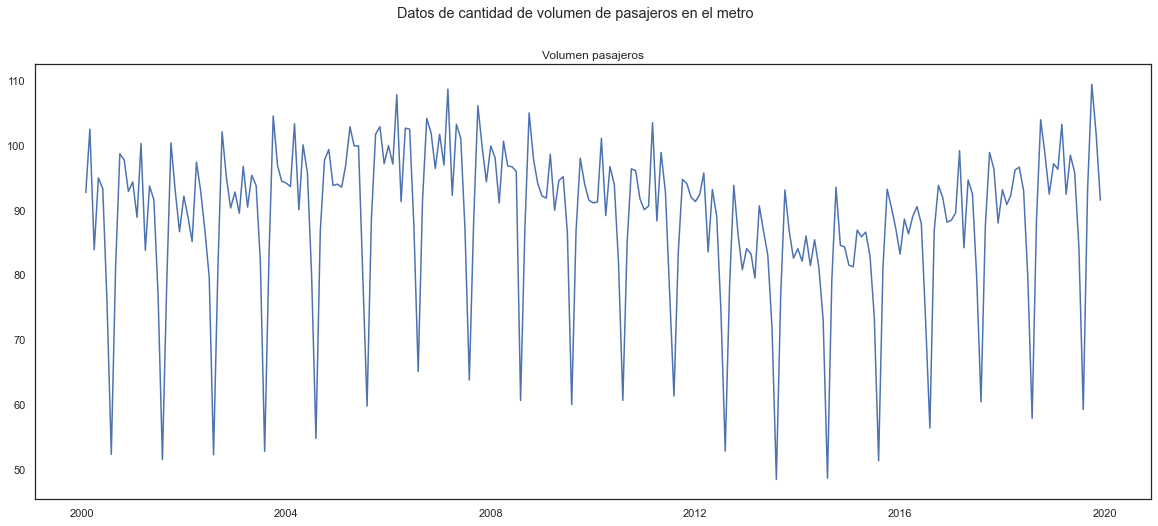

In [119]:
fig, (ax1) = plt.subplots(1,1,figsize=(20,8))
fig.suptitle("Datos de cantidad de volumen de pasajeros en el metro")
ax1.plot(df.volumenMetro)
ax1.set_title('Volumen pasajeros')
fig.show()

Vamos como tenemos un total de $239$ filas. La media mensual de pasajeros es de casi $86$ mil pasajeros menuales con una desviación típica de $12$ mil, siendo el minimo registro de $48$ mil y el máximo $109$ mil pasajeros. Esta tabla la podemos representar en un gráfico de cajas y bigotes (boxplot)

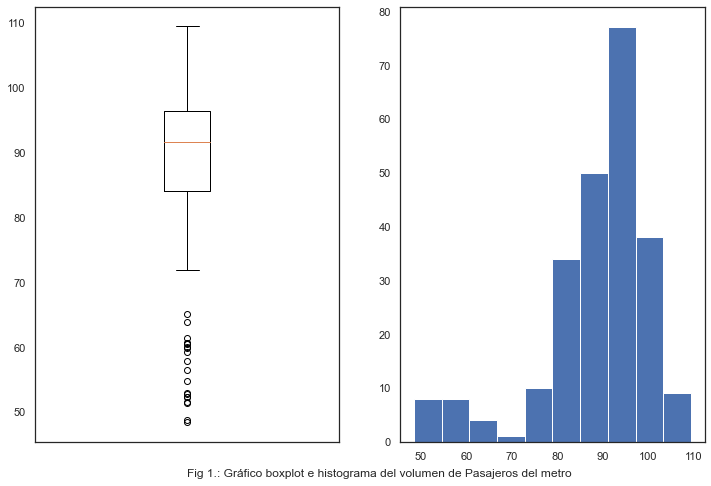

In [123]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,8))
ax1.boxplot(df['volumenMetro'])
ax1.text(1,40, "Fig 1.: Gráfico boxplot e histograma del volumen de Pasajeros del metro")
ax1.set_xticklabels('')
ax2.hist(df['volumenMetro'])
fig.show()

En ambos gráficos se ve como la distribución no es simétrica, pues la media se situa a por encima de la mediana. Además, vemos como tenemos valores extremos o atípicos en los datos cercanos al mínimo, esto es normal al tratarse de una distribución no simétrica.

Podemos realizar una descomposición de serie temporal, para analizar la tendencia, la componente estacionaria y los residuos.

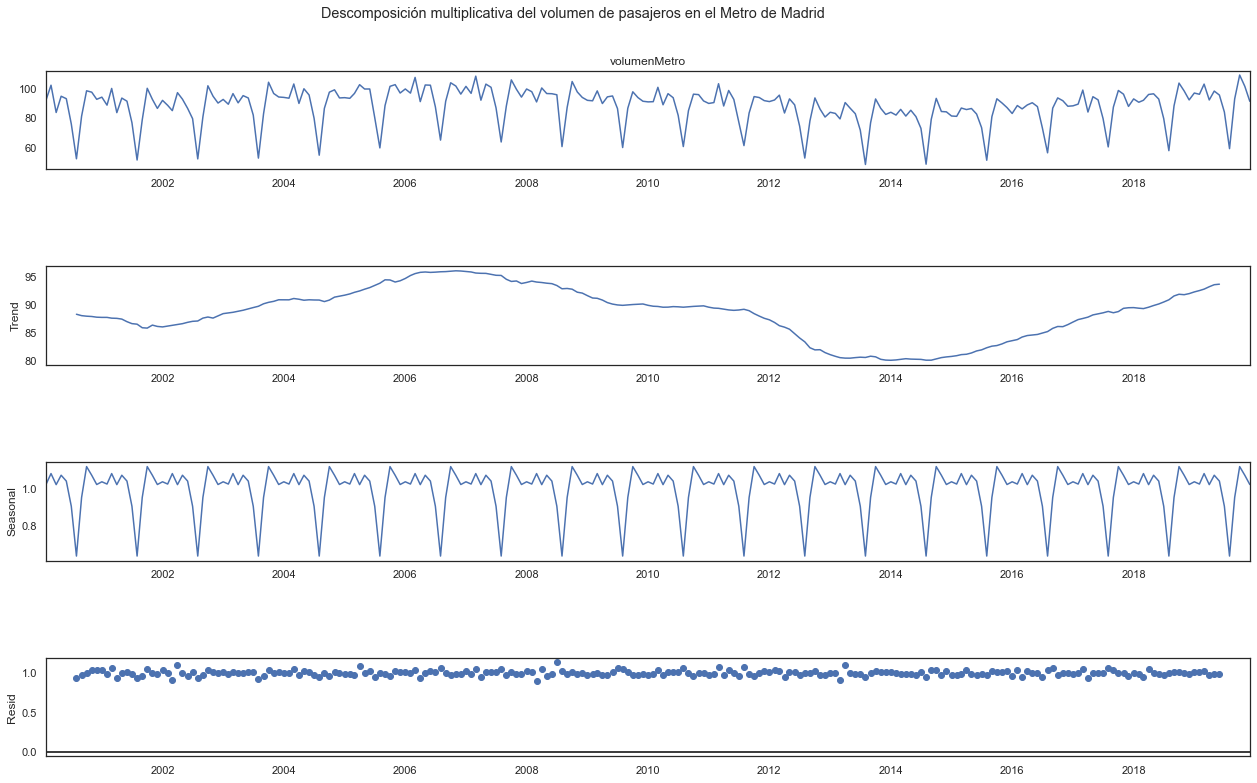

In [125]:
resultV=seasonal_decompose(df['volumenMetro'], model='multiplicable')
fig = resultV.plot()
fig.suptitle('Descomposición multiplicativa del volumen de pasajeros en el Metro de Madrid')
fig.set_size_inches(20, 12)
fig.show()

Viendo la serie, vemos como la tendencia parece que tiene un comportamiento cíclico, pues empieza con tendencia ascendiente, pasa a descendiente y posteriormente a partir del año $2014$ vuelve a producirse una bajada. Aunque no hemos querido representar los datos apartir del año $2020$ debido a la pandemia, la tendencia seguiría el mismo comportamiento descrito, pues quizá no empeoraría la calidad del modelo.

Si nos fijamos en la componente estacional, es muy claro que existe estacionalidad, podemos ver los coeficientes en la siguiente tabla:

In [135]:
print('Componente estacional de volumen pasajeros')
tabla1 = resultV.seasonal.to_frame().head(12).T
tabla1.columns = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
tabla1

Componente estacional de volumen pasajeros


,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
seasonal,1.026063,1.082559,1.022927,1.073622,1.042025,0.906174,0.637445,0.953794,1.120254,1.073352,1.02354,1.038242


Analizando estos coeficientes, vemos como claramente en Julio se produce una bajada muy pronunciada de los pasajeros en el metro, con un $36$% menos de viajeros, recordemos que los datos son de pasajeros registrados en el consorcio de transporte, es decir, únicamente viajeros que tienen el abono transporte, esto tiene sentido pues en Junio, Julio y Agosto es periodo vacacional. El mayor pico de viajeros se registra cada año en Septiembre, con $12$% más de usuarios, con la vuelta de vacaciones, esto es lo que produce los picos tan pronunciados en la gráfica.

Veamos ahora los residuos:

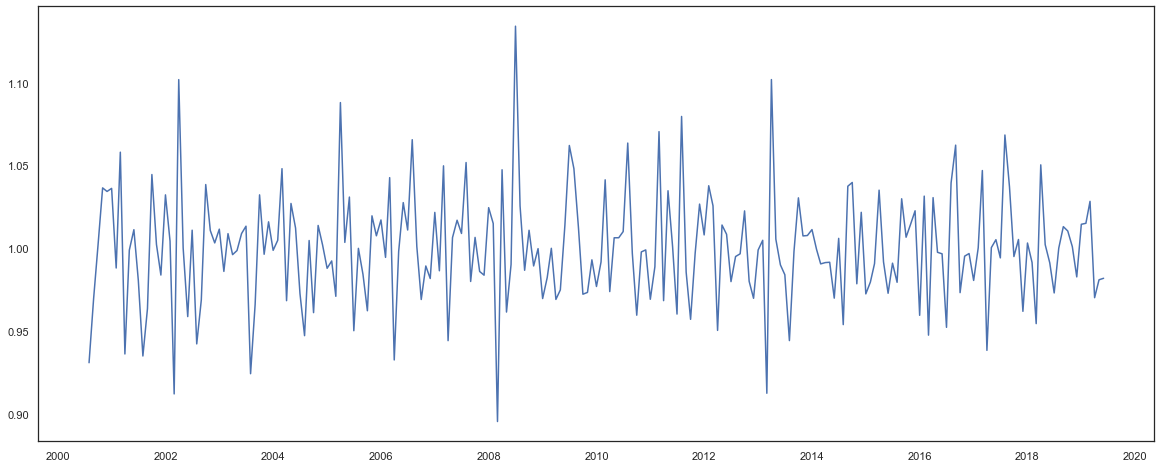

In [146]:
plt.figure(figsize=(20,8))
plt.plot(resultV.resid.to_frame())
plt.show()

In [154]:
tabla2 = resultV.resid.to_frame().iloc[11:23].T
tabla2.columns = ['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre']
print('Tabla de residuos del año 2001')
tabla2

Tabla de residuos del año 2001


,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
resid,1.036299,0.98815,1.058182,0.936173,0.998952,1.011319,0.980676,0.934949,0.963582,1.044666,1.002424,0.983892


In [155]:
print('Tabla de estadisticos de los residuos')
resultV.resid.to_frame().describe().T

Tabla de estadisticos de los residuos


,count,mean,std,min,25%,50%,75%,max
resid,227.0,0.999775,0.034096,0.895321,0.980063,0.999391,1.014903,1.13436


Veamos como los residuos tienen media $1$, con una desviación típica $0.034$ podemos continuar con el análisis viendo el autocorrelograma y el autocorrelograma parcial con un retardo de 48 meses

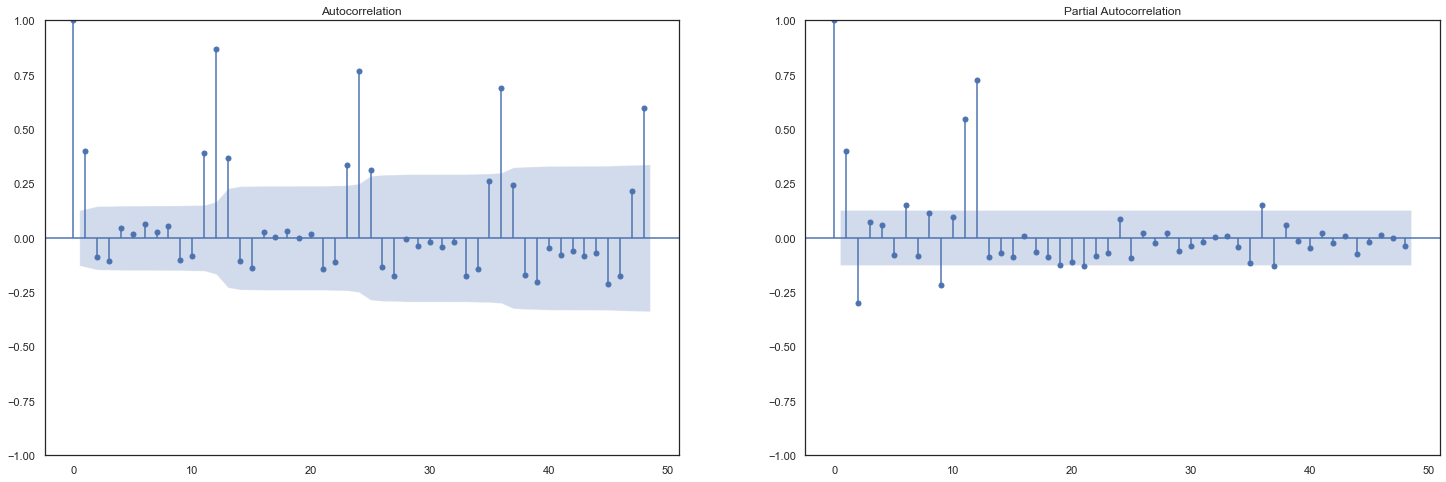

In [210]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,8))
ax1 =plot_acf(df['volumenMetro'], lags= 48 , ax = ax1)
ax2 = plot_pacf(df['volumenMetro'], lags= 48, method= 'ywm', zero=True , ax = ax2)
fig.show()